In [1]:
!pip install --upgade tables
!pip install eli5


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --upgade


In [17]:
!pip install numpy==1.15.4

     |████████████████████████████████| 13.9MB 321kB/s 
ERROR: tensorflow 1.15.0 has requirement numpy<2.0,>=1.16.0, but you'll have numpy 1.15.4 which is incompatible.
ERROR: plotnine 0.6.0 has requirement numpy>=1.16.0, but you'll have numpy 1.15.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: astropy 4.0 has requirement numpy>=1.16, but you'll have numpy 1.15.4 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.17.5
    Uninstalling numpy-1.17.5:
      Successfully uninstalled numpy-1.17.5


In [2]:
import pandas as pd
import numpy as np

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score

import eli5
from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [3]:
cd "/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_two/dw_matrix_car"

/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_two/dw_matrix_car


In [14]:
ls

data/  day2_visualisation.ipynb  LICENSE  README.md


## Wczytywanie danych

In [4]:
df = pd.read_hdf('data/car.h5')
df.shape

(106494, 155)

In [5]:
df.columns

Index(['breadcrumb', 'created_at', 'price_currency', 'price_details',
       'price_value', 'seller_address', 'seller_name', 'seller_type',
       'feature_czujniki-parkowania-przednie',
       'feature_poduszka-powietrzna-chroniąca-kolana',
       ...
       'param_pearl', 'param_stan', 'param_wersja', 'param_emisja-co2',
       'param_body-type', 'param_matowy', 'param_bezwypadkowy',
       'param_akryl-(niemetalizowany)', 'param_monthly-payment-value',
       'car_id'],
      dtype='object', length=155)

## Dummy Model

In [6]:
df.select_dtypes(np.number).columns

Index(['price_value', 'car_id'], dtype='object')

In [7]:
feats = ['car_id']
X = df[ feats ].values
y = df['price_value'].values

model = DummyRegressor()
model.fit(X,y)
y_pred = model.predict(X)

mae(y,y_pred)

39465.934630440985

In [8]:
[x for x in df.columns if 'price' in x]

['price_currency', 'price_details', 'price_value']

In [9]:
df['price_currency'].value_counts()

PLN    106290
EUR       204
Name: price_currency, dtype: int64

In [10]:
df['price_currency'].value_counts(normalize=True)

PLN    0.998084
EUR    0.001916
Name: price_currency, dtype: float64

In [12]:
df = df[ df['price_currency'] != 'EUR' ]
df.shape

(106290, 155)

## Features

In [0]:
SUFFIX_CAT = '__cat'
for feat in df.columns:
  if isinstance(df[feat][0],list):continue
  
  factorized_values = df[feat].factorize()[0]
  if SUFFIX_CAT in feat:
    df[feat] = factorized_values
  else:
    df[feat + SUFFIX_CAT] = factorized_values

In [19]:
cat_feats = [x for x in df.columns if SUFFIX_CAT in x]
cat_feats = [x for x in cat_feats if 'price' not in x]
len(cat_feats)

151

In [21]:
X = df[ cat_feats ].values
y = df['price_value'].values

model = DecisionTreeRegressor(max_depth=5)
scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error')
np.mean(scores)


-19566.588937368328

In [23]:
m = DecisionTreeRegressor(max_depth=5)
m.fit(X,y)

imp = PermutationImportance(m,random_state=0).fit(X,y)
eli5.show_weights(imp, feature_names=cat_feats)

Weight,Feature
0.2533 ± 0.0040,param_napęd__cat
0.2008 ± 0.0047,param_faktura-vat__cat
0.1943 ± 0.0088,param_stan__cat
0.1423 ± 0.0086,param_rok-produkcji__cat
0.0629 ± 0.0047,param_moc__cat
0.0424 ± 0.0014,feature_kamera-cofania__cat
0.0412 ± 0.0008,param_skrzynia-biegów__cat
0.0286 ± 0.0037,param_marka-pojazdu__cat
0.0191 ± 0.0022,param_pojemność-skokowa__cat
0.0163 ± 0.0005,feature_bluetooth__cat


In [31]:
df['param_napęd'].value_counts()

Na przednie koła                 65926
Na tylne koła                     8589
4x4 (stały)                       6945
4x4 (dołączany automatycznie)     6859
4x4 (dołączany ręcznie)           1628
Name: param_napęd, dtype: int64

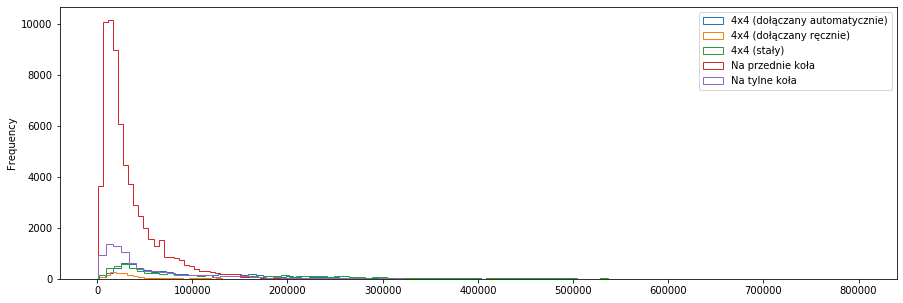

In [56]:
feat_groupby='param_napęd'
feat_agg='price_value'
(
    df
      .groupby(feat_groupby)[feat_agg]
  ).plot(kind='hist',bins=100,histtype='step',legend=True,figsize=(15,5));

In [54]:
df_podgrupa1=df[ df['param_napęd'] != 'Na przednie koła' ]
df_podgrupa1.shape

(40364, 309)

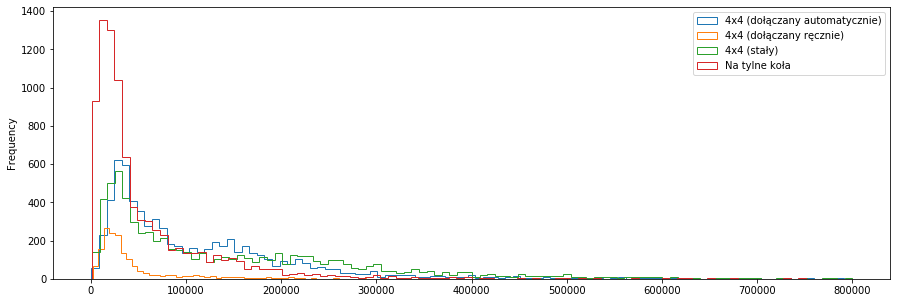

In [57]:

feat_groupby='param_napęd'
feat_agg='price_value'
(
    df_podgrupa1
      .groupby(feat_groupby)[feat_agg]
  ).plot(kind='hist',bins=100,histtype='step',legend=True,figsize=(15,5));